In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evallm
from automata.fa.dfa import DFA
import tqdm.auto as tqdm

In [3]:
import itertools
from permacache import stable_hash

In [4]:
from evallm.prompting.transducer_prompt import (
    ChainOfThoughtPromptRealExampleNoExplanation,
    BasicSequencePrompt,
    SequencePromptWithExplanation,
    SequencePromptWithExplanationChainOfThought,
)
from evallm.experiments.transducer_experiment import (
    current_transducer_experiments,
    compute_relative_to_null,
    compute_relative_to_ngram,
    print_example,
    bottom_quartile_outcome,
)
from evallm.experiments.transducer_plotting import (
    plot_all_absolute_results_single_graph,
)

In [5]:
num_states_options_full = (3, 5, 7)

In [6]:
none = current_transducer_experiments(
    "none",
    num_states_options=num_states_options_full,
    num_dfas=1000,
    num_sequence_symbol_options=range(30, 500 + 1, 10),
    just_stats=True,
)

In [7]:
results = {
    "llama3-8B": current_transducer_experiments(
        "meta-llama/Meta-Llama-3-8B",
        num_states_options=num_states_options_full,
        num_dfas=30,
        num_sequence_symbol_options=(30, 60, 90, 120, 180, 240, 300, 400, 500),
    ),
    "gpt-35-nonchat": current_transducer_experiments(
        "gpt-3.5-turbo-instruct",
        num_dfas=30,
        num_states_options=num_states_options_full,
        num_sequence_symbol_options=(30, 120, 240, 300, 400),
    ),
    "gpt-4o-mini + just seq": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-mini-2024-07-18",
        cot_prompt=BasicSequencePrompt.for_setting,
        num_states_options=num_states_options_full,
        num_sequence_symbol_options=(30, 120, 240, 500),
    ),
    "gpt-4o-mini + explanation": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-mini-2024-07-18",
        cot_prompt=SequencePromptWithExplanation.for_setting,
        num_states_options=num_states_options_full,
        num_sequence_symbol_options=(30, 120, 240, 500),
    ),
    "gpt-4o-mini + explanation + cot": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-mini-2024-07-18",
        cot_prompt=SequencePromptWithExplanationChainOfThought.for_setting,
        num_states_options=num_states_options_full,
        num_sequence_symbol_options=(30, 120, 240, 500),
    ),
    "gpt-4o + just seq": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-2024-05-13",
        cot_prompt=BasicSequencePrompt.for_setting,
        num_states_options=num_states_options_full[:1],
        num_sequence_symbol_options=(30, 120, 240, 500),
    ),
}

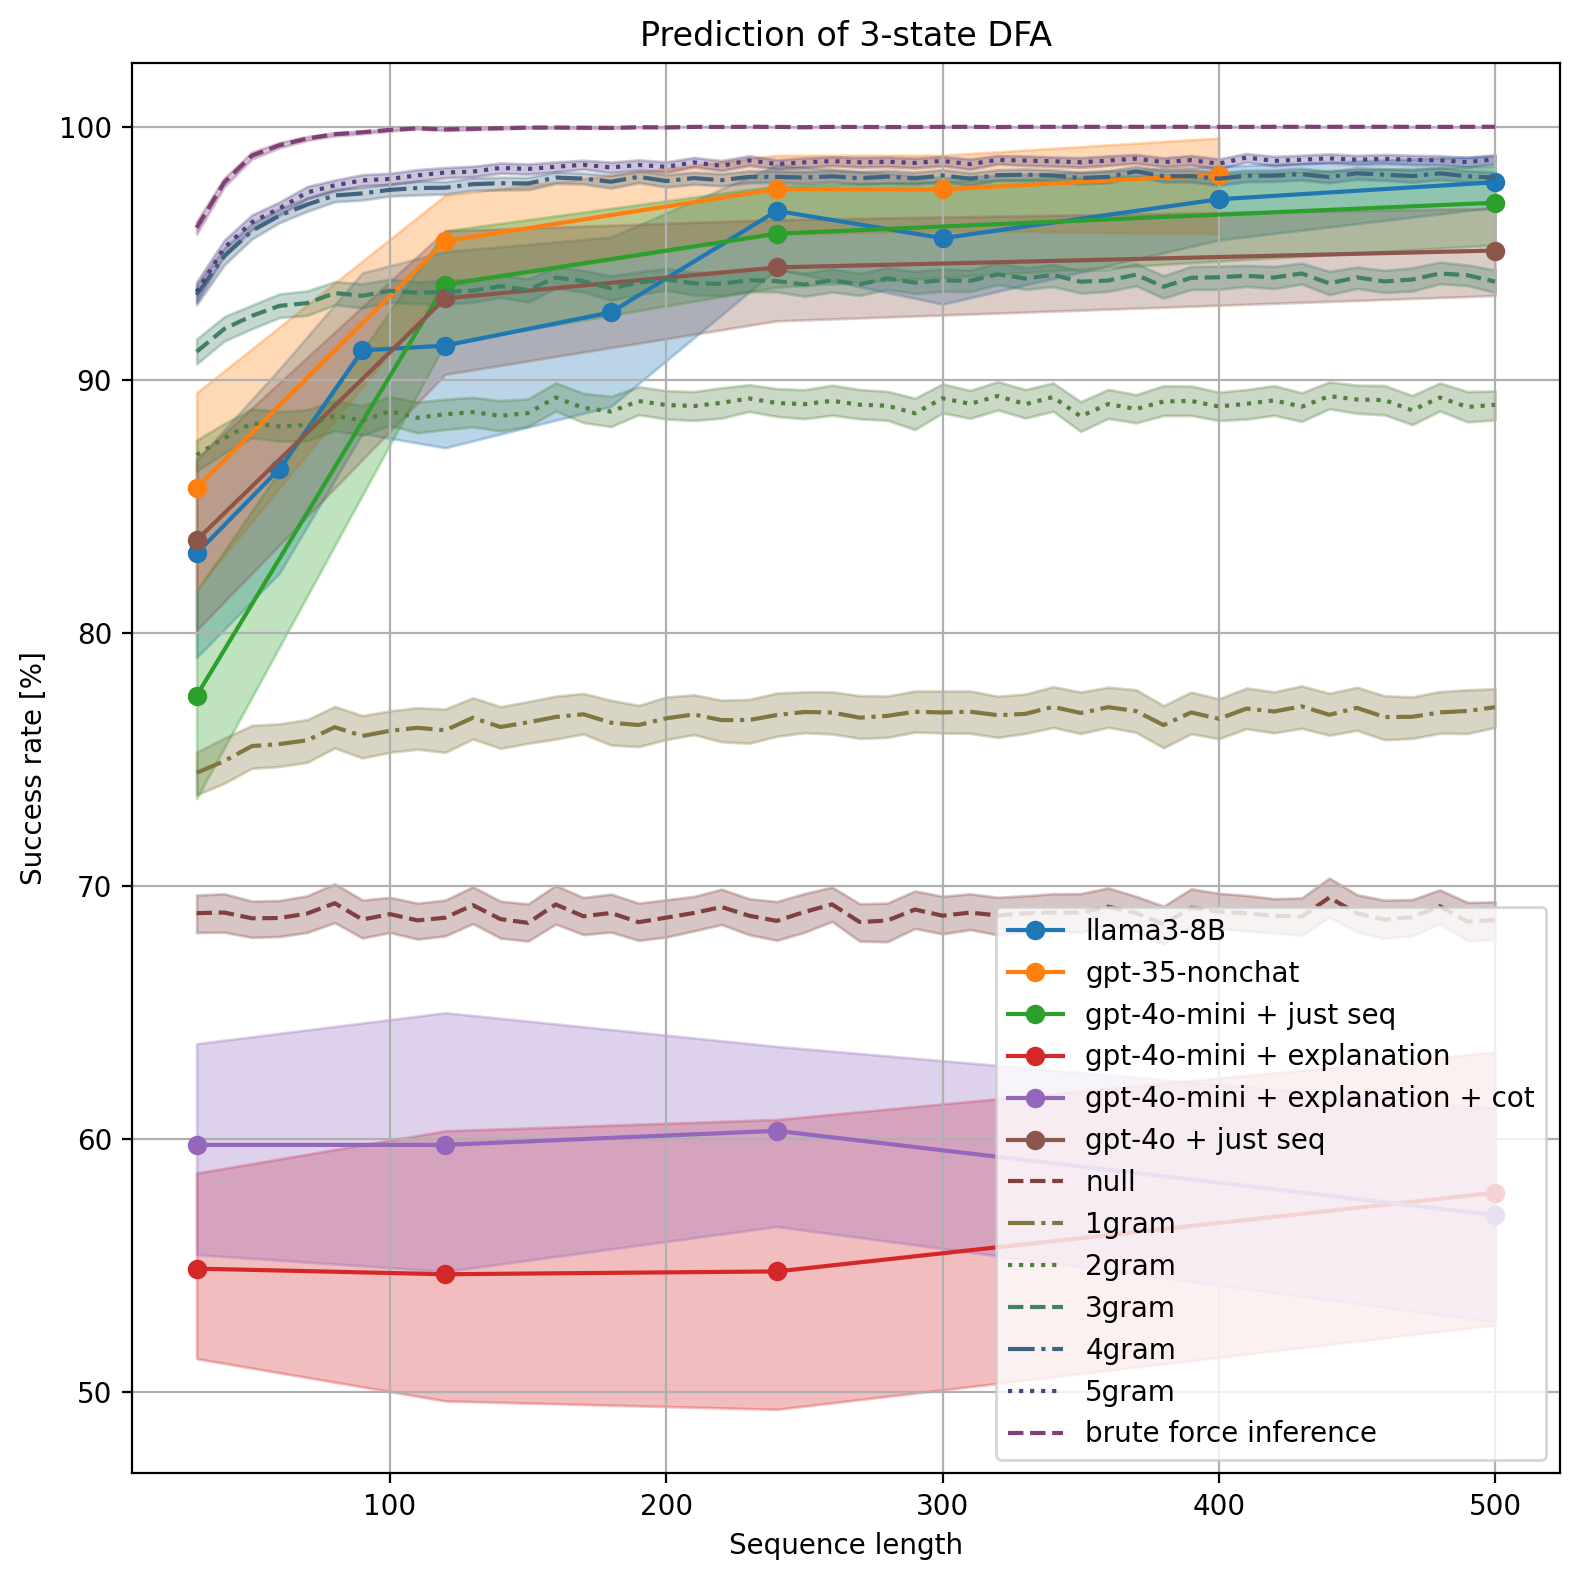

In [8]:
plot_all_absolute_results_single_graph(results, none, 3, ignore_na=True)

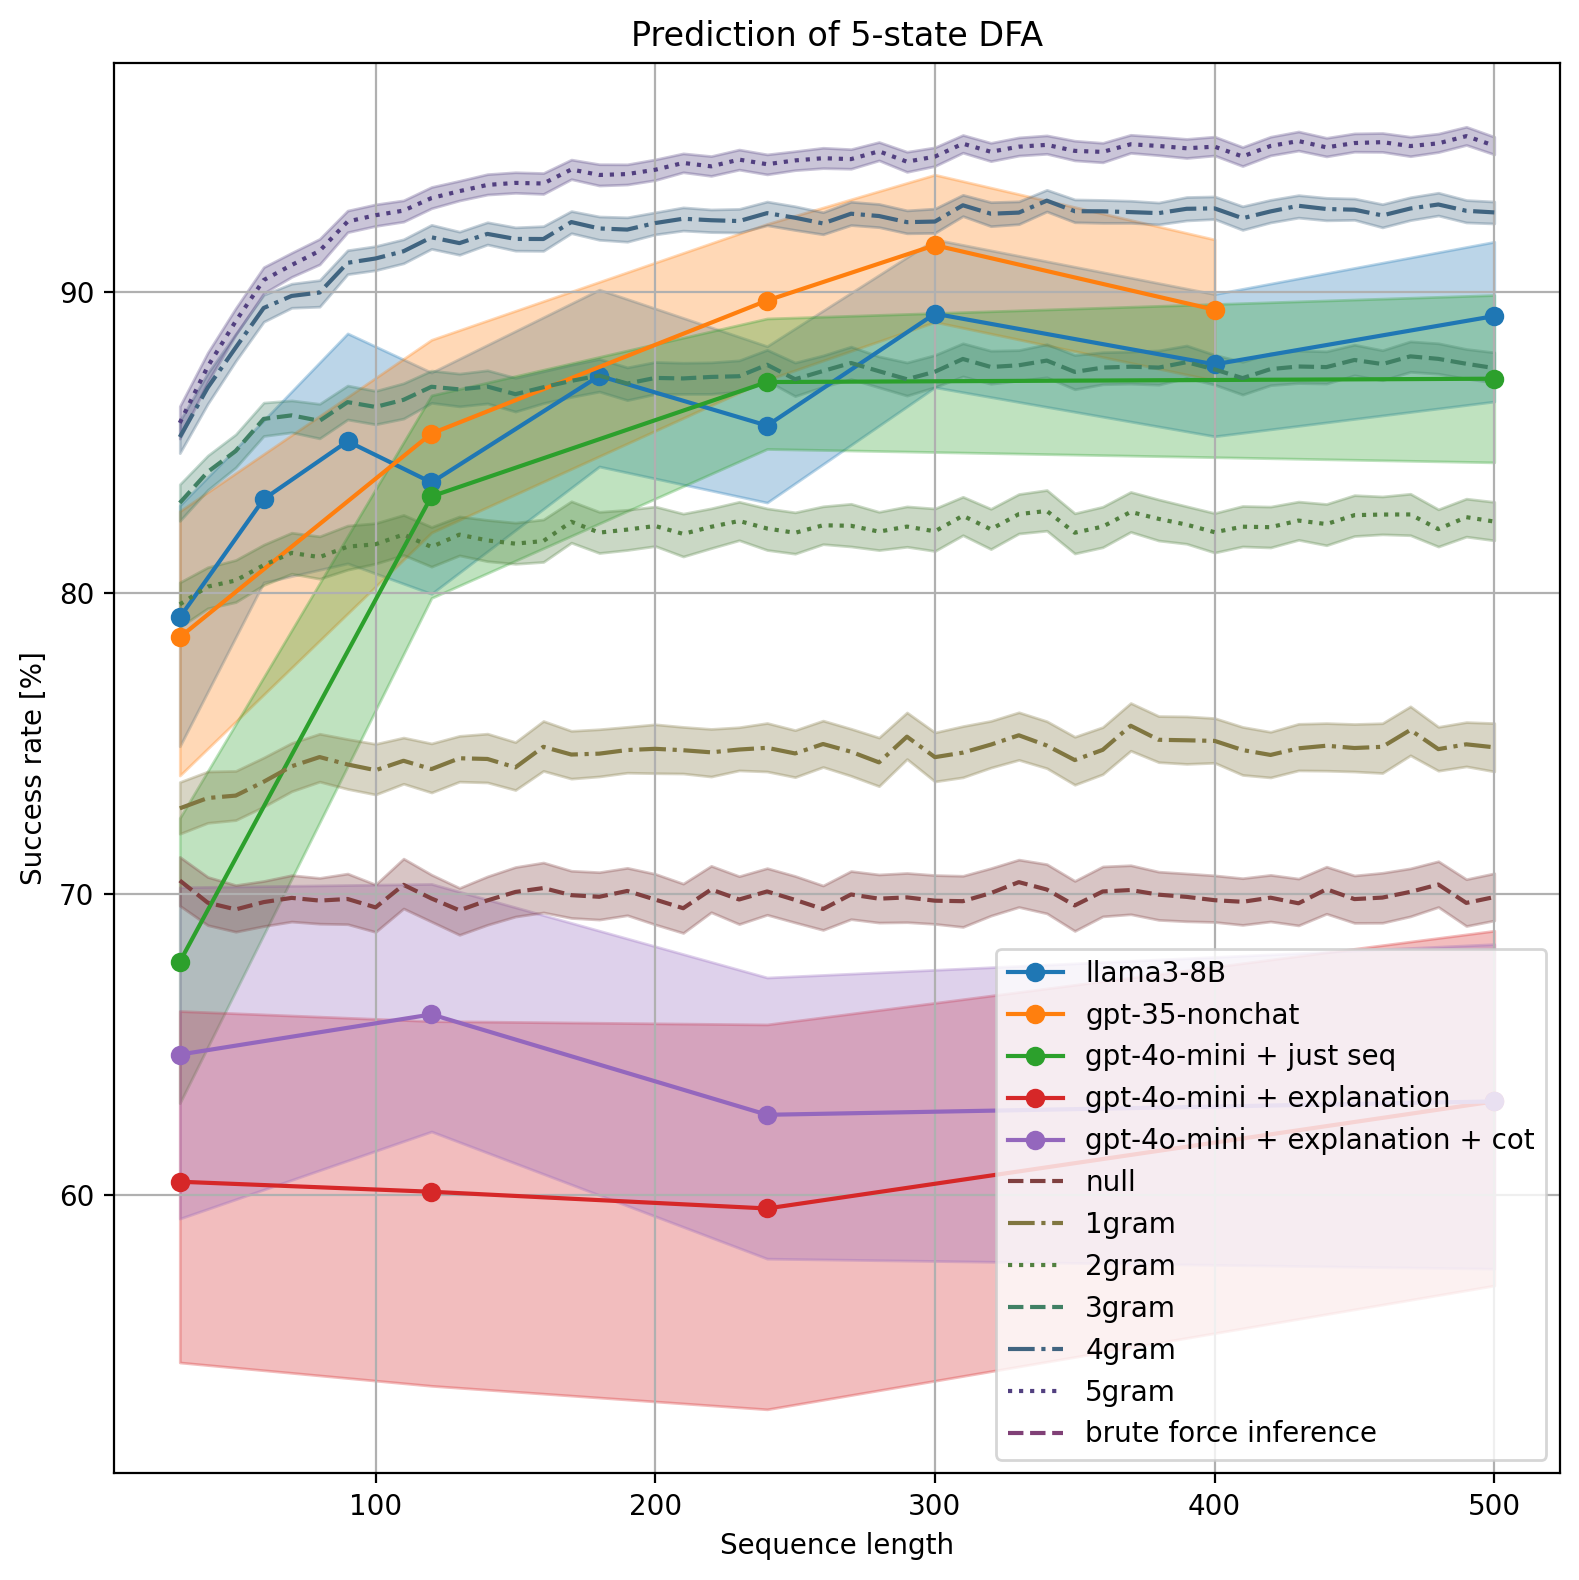

In [9]:
plot_all_absolute_results_single_graph(results, none, 5, ignore_na=True)

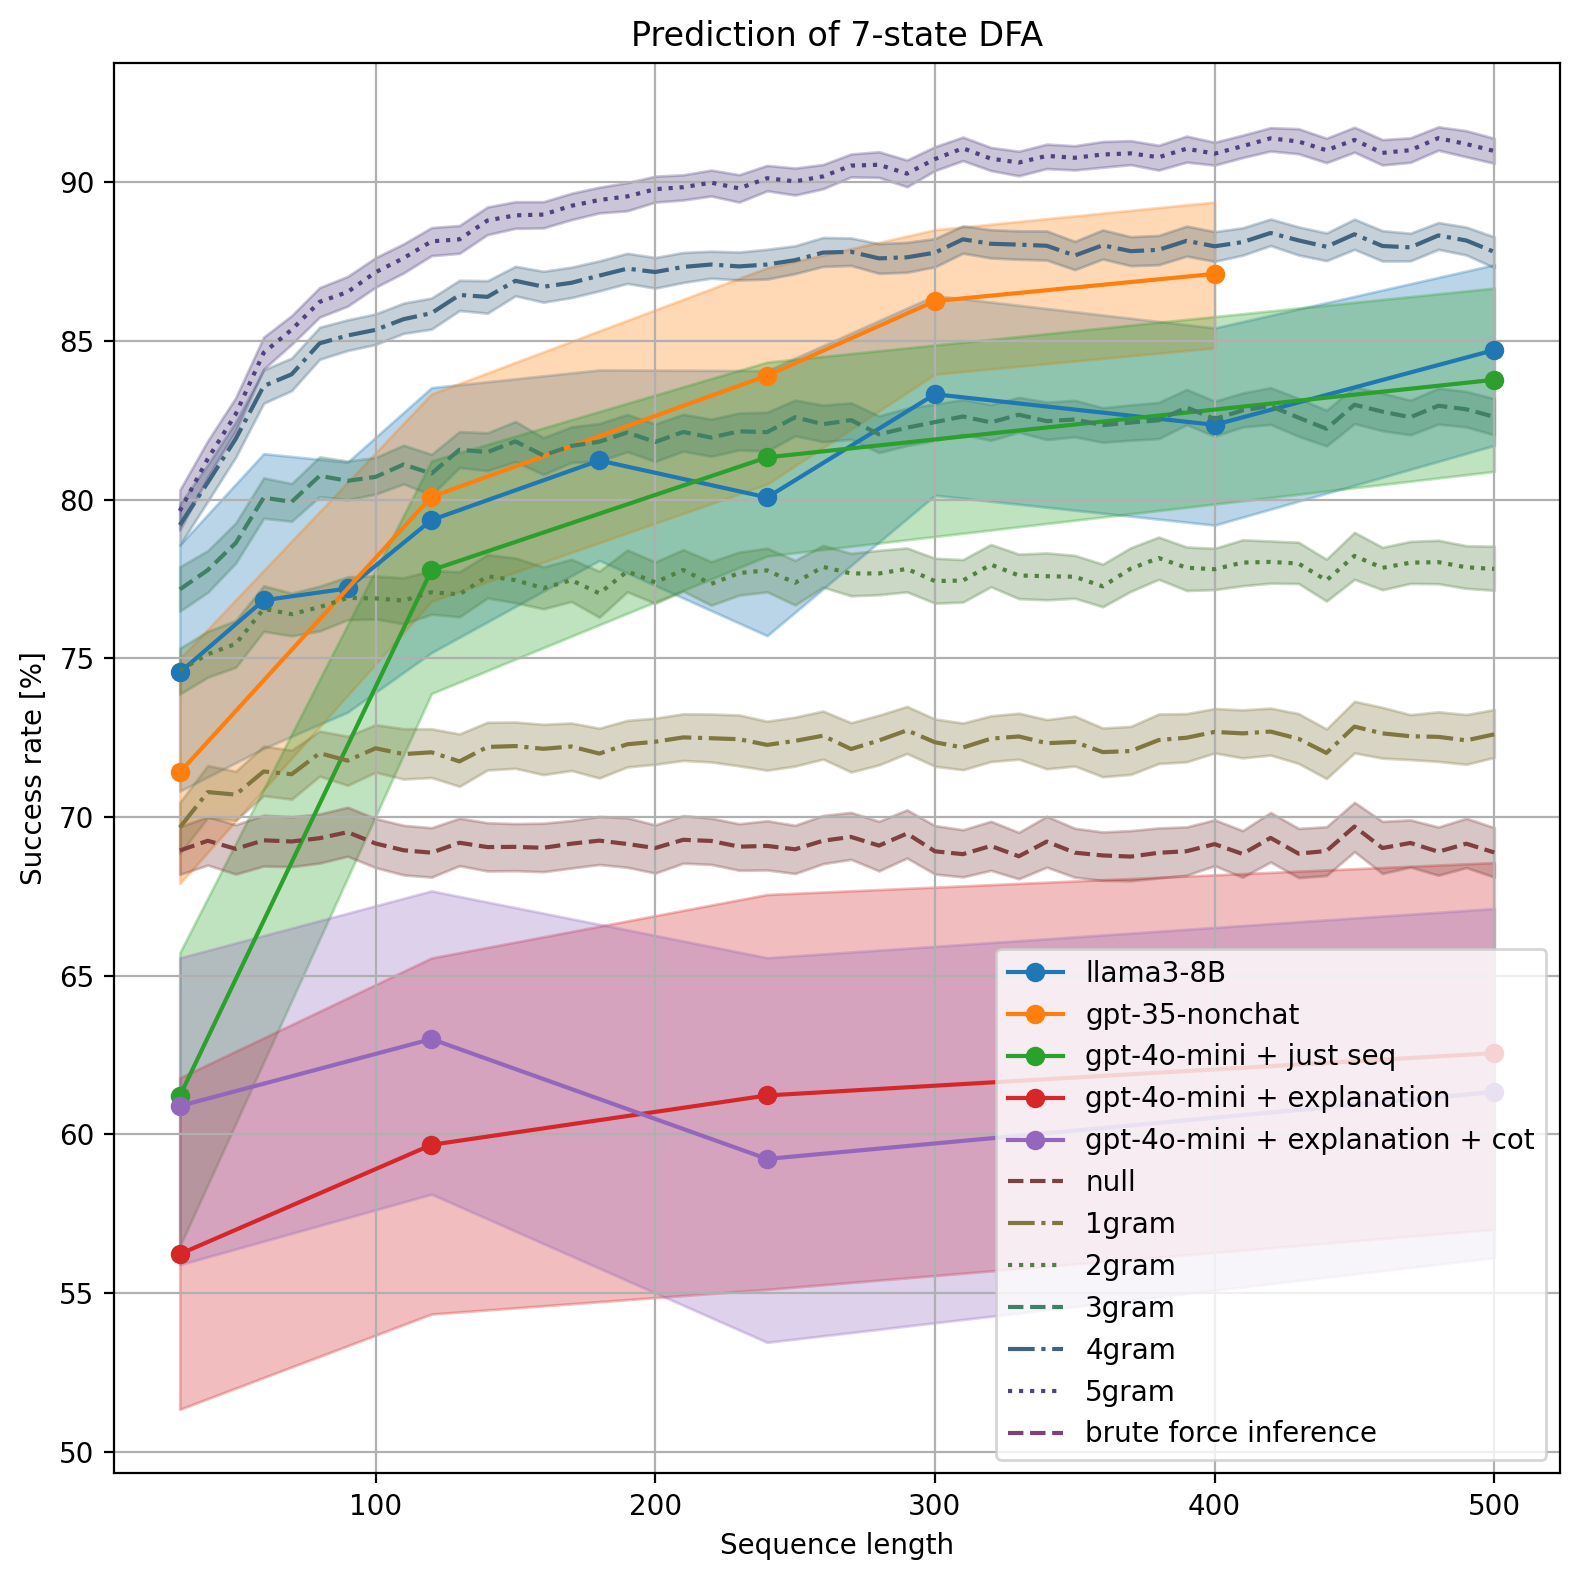

In [10]:
plot_all_absolute_results_single_graph(results, none, 7, ignore_na=True)

In [11]:
prompter_basic = evallm.prompting.transducer_prompt.SequencePromptWithExplanation(
    30, 3, version=0
)

In [12]:
u = results["gpt-4o-mini + explanation"][5][30]
print_example(
    "gpt-4o-mini-2024-07-18",
    prompter_basic,
    bottom_quartile_outcome(u),
)

********* EXAMPLE 0: CORRECT ***********
######### SYSTEM ############

######### USER ############
A DFA is a finite-state machine that accepts or rejects a given string of symbols, by running through a n-state sequence uniquely determined by the string.

I have a 5-state DFA model that outputs either 0 or 1 after each element I input. 1 indicates that the input string thus far results in a "valid" state, and 0 indicates that it does not. I collect the inputs and outputs into an input sequence and an output sequence. Infer the underlying DFA model to predict the next integer in the output sequence. Only output the next output and nothing else.

Input sequence: a, b, a, a, b, a, b, a, c, a, b, c, c, a, c, b, a, a, b, a, a, c, b, a, a, a, c, b, a, b
Output sequence: 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 
######### RESPONSE: CORRECT ############
1

********* EXAMPLE 1: WRONG ***********
######### SYSTEM ############

######### USER #######